In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import display, HTML
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost
import shap
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.inspection import plot_partial_dependence

In [3]:
#function for facets dive data exploration
def facets_plot(df):
    jsonstr = df.to_json(orient='records')
    HTML_TEMPLATE = """
            <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
            <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
    html = HTML_TEMPLATE.format(jsonstr=jsonstr)
    return display(HTML(html))

In [4]:
# function for partial dependence plots -- marginal effect of x on y, complement features
#https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html
#https://scikit-learn.org/stable/modules/partial_dependence.html#
#https://www.kaggle.com/dansbecker/partial-dependence-plots

def pdp_plot(model,train,ft):  #input fitted model, training data, and variables of interest
    
    ft.append(tuple(ft))
    
    _, ax = plt.subplots(ncols=3, figsize=(15, 6))
    #ax[0].set_xlim(-120,120)
    #ax[2].set_xlim(-120,120)
    display = plot_partial_dependence(
        model,
        train,
        ft,
        kind="average",
        grid_resolution=20,
        ax=ax,
    )

    display.figure_.suptitle(
        "Partial dependence of on-time graduation on " +str(ft)+", With LightGBM"
    )
    display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

In [5]:
#create function for single line shap plot

def shap_plot(model,testset,var1=None,var2=None):  #pass var1 / var2 to get a dependence plot as well
    shap_values = shap.TreeExplainer(model).shap_values(testset)
    shap.summary_plot(shap_values[1], X_test)
    
    #pass dense verison for plotting
    #X_test_array = X_test.to_numpy()
    if var1 == None:
        pass
    else:
        shap.dependence_plot(var1,shap_values[1],X_test,interaction_index=var2)
        #Output of classifier is in terms of log odds
        #shap.summary_plot(1/(1+np.exp(-shap_values)), X_test_array, feature_names=features.columns)

In [6]:
def lgbm_plot(model,var=None,tree_index=0): #pass var to get a split point histo

    #feature importances per the lgb model -- current = # of times variable was used to split
    lgb.plot_importance(trees)

    #aggregate-ish version of 'at what value does this feature tend to matter to outcome
    if var==None:
        pass
    else:
        lgb.plot_split_value_histogram(trees,var,figsize=(12,8))

    #plot_tree function
    lgb.plot_tree(trees,tree_index=tree_index,show_info=['data_percentage','internal_count','split_gain'],
                  figsize=(100,75),orientation='vertical')
    
    #same as above but bigger?
    #lgb.create_tree_digraph(trees,tree_index=0,show_info=['data_percentage','internal_count'])
    #graph.render(view=True)   #this exports to pdf

 Predict Process
 
     add in other vars from other datasets (identify level of vars, so they can be added routinely)

     some feature engineering

     some transformations (dummy encoding etc)

 Baseline Model Examples
    
    on time hs grad rates (% prob)
    
    college-going rates (% prob)
    
    Wages earned (regression)
    
    if time permits: employment location (NE, other regions) (multiclass-prob %)
    if time permits: dealing with multicollinearity -- tree clustering to group by correlation and select 1 (MC IS a problem if            we want to derive feature importances - not as much if raw prediction is goal, and using tree based models
 
 How to display, understand 'when' things happen in predict space?
 
     decision trees output (soft decision trees, or RF visual?)
     
     SHAP interaction values
     
     parial dependence plots

 template-ify process for 'predict', or at least the process for deciding how to choose model/visual/output
     
       in case of SHAP / PDP / Tree-based Viz, it shouldn't matter what model or output type
       
        What are the features that can be tuned by decision makers? What are the most important features per the model?                                      Effect Sizes?

## Import Files / Preprocessing

In [7]:
#read file, drop dupes that occur across all columns
stu = pd.read_csv('Students_HS_v1.csv')


#identify targets
target1  = stu['HS_Grad']
target2  = stu['HS_Grad_ontime']


#first set of features  
features = stu.drop(['HS_Grad','HS_Grad_ontime','nswersguid','SchoolNumber'],axis=1)

#features[['Gender','Race1','lang','DistrictNumber1']] = features[features.columns[features.dtypes == 'O']].astype('category')


#get dummies
featuresdum = pd.get_dummies(stu.drop(['HS_Grad','HS_Grad_ontime','nswersguid','SchoolNumber'],axis=1))
featuresdum_dropfirst = pd.get_dummies(stu.drop(['HS_Grad','HS_Grad_ontime','nswersguid','SchoolNumber'],axis=1),drop_first=True)

stu.shape

(22541, 34)

In [ ]:
#split data into train/test 
X_train,X_test,y_train,y_test = train_test_split(featuresdum_dropfirst,target2,test_size=0.30,random_state=123)

#instantiate and train model
trees = lgb.LGBMClassifier()
trees.fit(X_train,y_train)

#gridsearchcv for best params

#5 fold CV score average
print(np.mean(cross_val_score(trees,X_train,y_train)))

0.9372544234411752


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


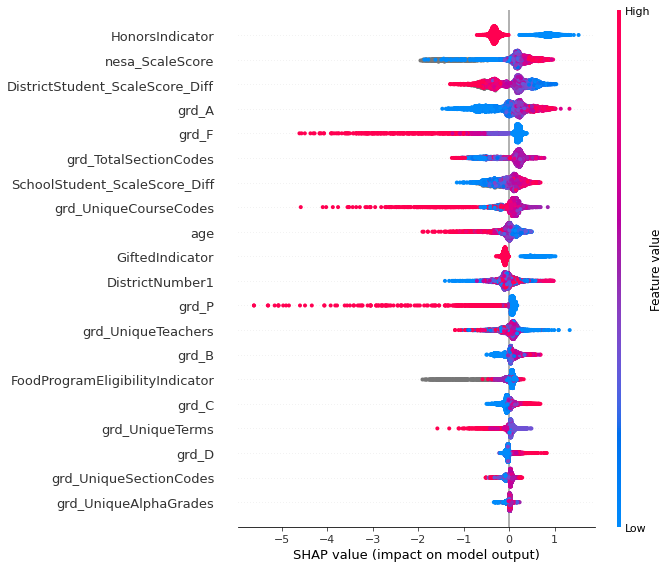

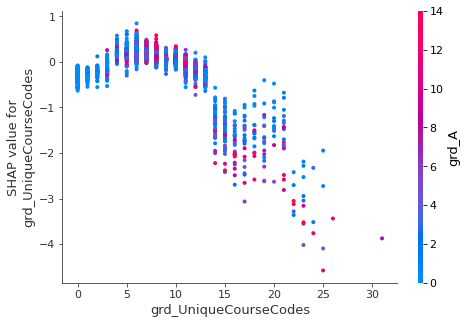

In [8]:
shap_plot(trees,X_test,'grd_UniqueCourseCodes','grd_A')

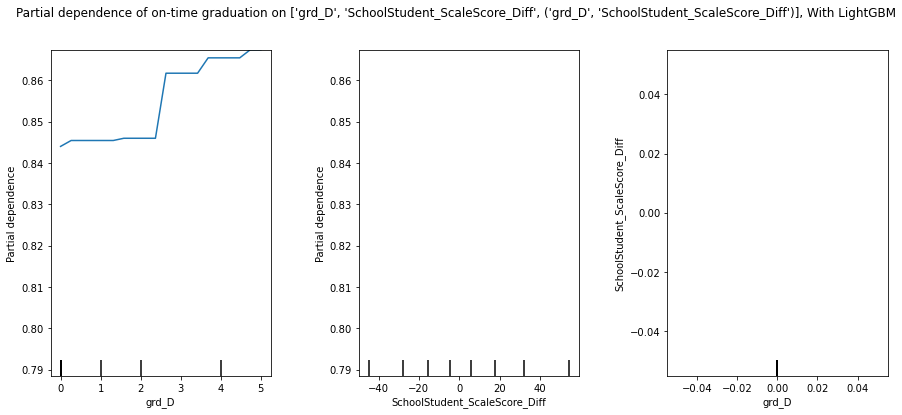

In [12]:
#pdp_plot(trees,X_train,['grd_A','grd_TotalSectionCodes'])
pdp_plot(trees,X_train,['grd_D','SchoolStudent_ScaleScore_Diff'])

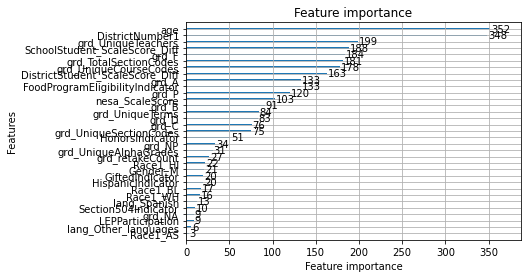

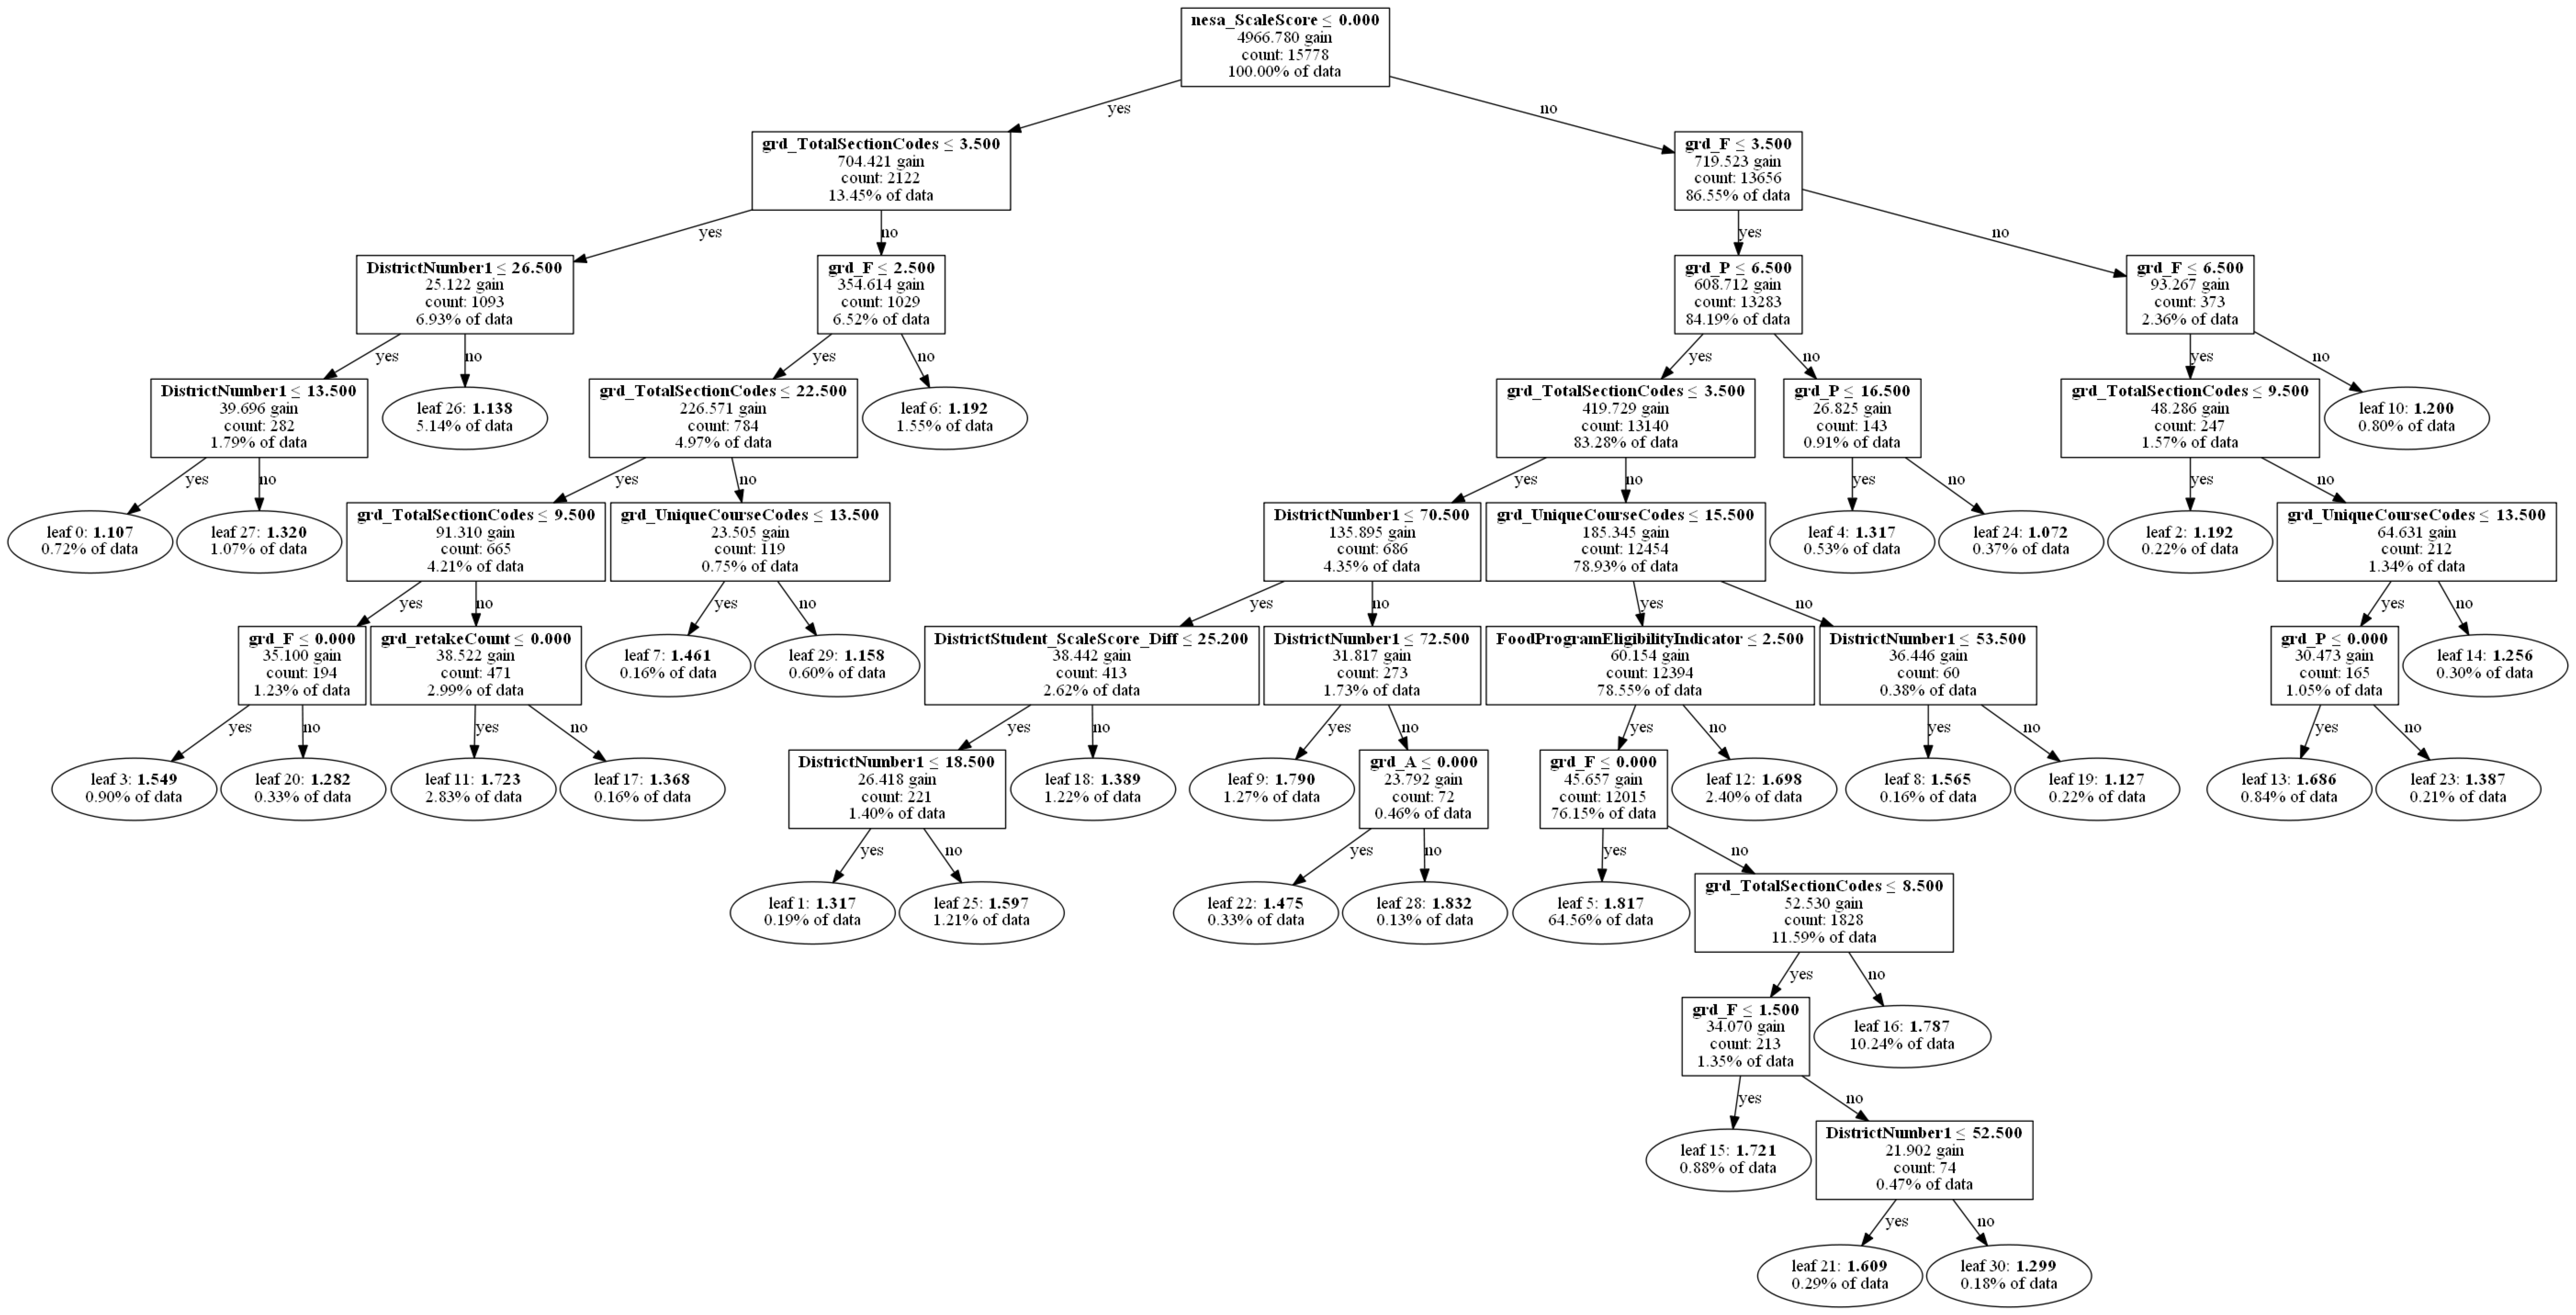

In [10]:
lgbm_plot(trees)